# `CLOUD.jl` - 1D linear advection-diffusion example

In [9]:
using CLOUD, OrdinaryDiffEq, Plots

## Define the physical problem

In [10]:
a = 1.0  # wave speed
b = 5.0e-2 # diffusion coefficient
L = 1.0  # domain length
T = 1.0  # end time for one period

initial_data = InitialDataSine(1.0,2π)
conservation_law = LinearAdvectionDiffusionEquation(a,b)
exact_solution = ExactSolution(conservation_law,initial_data);

## Set discretization parameters

In [11]:
M = 4
p = 5
form = WeakConservationForm()
strategy = PhysicalOperator()

ode_algorithm = CarpenterKennedy2N54()
dt = 0.05*(L/M)/(a*(2*p+1));
write_interval = floor(Int, T/(dt*100));

## Set up a `NodalTensor` scheme of degree `p` with `M` elements

In [12]:
reference_approximation = ReferenceApproximation(
    NodalTensor(p), Line())

mesh = uniform_periodic_mesh(
    reference_approximation.reference_element, (0.0,L), M)

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T), strategy,
     "results/advection_diffusion_1d/", overwrite=true, clear=true);

## Run the solver and print timer outputs

In [13]:
ode_problem = semidiscretize(conservation_law,
    spatial_discretization,
    initial_data, 
    form,
    (0.0, T),
    strategy)
save_solution(ode_problem.u0, 0.0, results_path, 0)
CLOUD_reset_timer!()
sol = solve(ode_problem, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, callback=save_callback(results_path, write_interval))
CLOUD_print_timer()
save_solution(last(sol.u), last(sol.t), results_path, "final")

 ────────────────────────────────────────────────────────────────────────────────
            Thread 1                    Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            1.85s /  55.0%            353MiB /  76.3%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 local residual         17.6k    475ms   46.8%  27.0μs    159MiB   59.3%  9.27KiB
   apply operators      17.6k   94.9ms    9.3%  5.38μs   29.3MiB   10.9%  1.70KiB
     volume terms       17.6k   30.0ms    2.9%  1.70μs   8.61MiB    3.2%     512B
     facet terms        17.6k   23.5ms    2.3%  1.33μs   7.53MiB    2.8%     448B
   gather ext state     17.6k   67.3ms    6.6%  3.82μs   20.4MiB    7.6%  1.19KiB
   eval visc num flux   17.6k   64.1ms    6.3%  3.64μs   23.1MiB    8.6%  1.34KiB
   eval nodal s

## Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [14]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)

println("L2 error:")
println(analyze(error_analysis, last(sol.u), exact_solution, T)...)
println("Conservation (initial/final/diff):")
println(analyze(conservation_analysis)...)
println("Energy (initial/final/diff):")
println(analyze(energy_analysis)...)

L2 error:
1.4856115459833738e-6
Conservation (initial/final/diff):
[-1.6653345369377348e-16][-7.632783294297951e-17][9.020562075079397e-17]
Energy (initial/final/diff):
[0.24999999999999986][0.004824075868541591][-0.24517592413145828]


## Plot the exact and numerical solutions

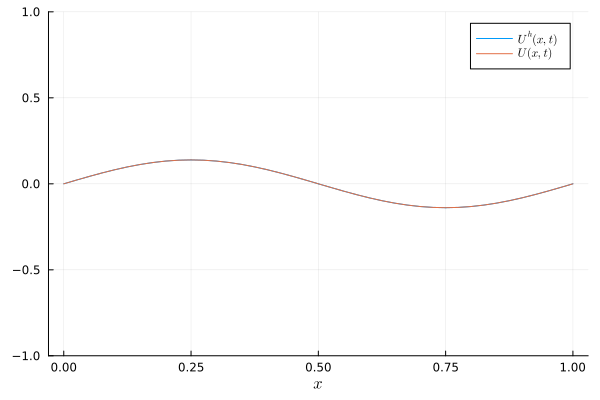

In [15]:
plot(spatial_discretization, last(sol.u), 
    exact_solution=exact_solution, time=T, ylims=[-1.0,1.0])

## Animate the numerical solution

┌ Info: Saved animation to 
│   fn = /Users/tristanmontoya/Research/CLOUD.jl/examples/advection_diffusion_solution.gif
└ @ Plots /Users/tristanmontoya/.julia/packages/Plots/AAjgN/src/animation.jl:139


Plots.AnimatedGif("/Users/tristanmontoya/Research/CLOUD.jl/examples/advection_diffusion_solution.gif")
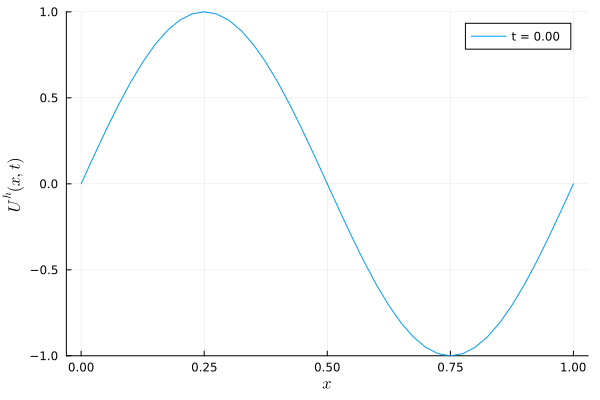

In [16]:
using Printf
anim = @animate for i ∈ eachindex(sol.u)
    plot(spatial_discretization, sol.u[i], 
        ylims=[-1.0,1.0], ylabel="\$U^h(x,t)\$",
        label=string("t = ", @sprintf "%.2f" sol.t[i]))
end
gif(anim, "advection_diffusion_solution.gif", fps = 10)